# Hydrogen Molecule

We compute the ground state energy for the hydrogen molecule using density functional theory. We solve the restricted Kohn-Sham equations for the orbital $\psi \in L^2(\mathbb R^3)$,
$$
\left(- \frac{1}{2} \Delta + v_\text{ext} + v_H + v_\text{xc} \right) \psi = \epsilon_0 \psi
$$
with the external potential induced by the nuclei given by
$$
v_\text{ext}(x) = - \frac{1}{|x - \vec R / 2|} - \frac{1}{|x + \vec R / 2|} + \frac{1}{|\vec R|}
$$
where $\vec R$ is the difference of nuclei positions centered around $0$, the Hartree potential
$$
v_H(x) = \int \frac{\rho(y)}{|x - y|} dy
$$
with the density $\rho = |\psi|^2$, and the exchange correlation potential
$$
v_\text{xc}(x) = - \left( \frac{3}{\pi}\right)^\frac{1}{3} \rho^\frac{1}{3}(x).
$$

## Discretization

The problem is discretized on a tensor grid in the restricted space $[-L, L]$ for $L = 8$ with $n = 50$ grid points in every direction. The Laplace is dicretized by finite differences.

In [1]:
using Plots
using LaTeXStrings
using Interact

# set up discrete space grid
n = 30 # even number to avoid singularity at 0
L = 5.
x = collect(linspace(-L, L, n + 2))[2:end-1]
Δx = x[2] - x[1]
X = kron(x, ones(n), ones(n))
Y = kron(ones(n), x, ones(n))
Z = kron(ones(n), ones(n), x)

# discretization of the Hamiltonian
L_1D = spdiagm((-0.5 / Δx^2 * ones(n - 1), -0.5 / Δx^2 * -2. * ones(n), -0.5 / Δx^2 * ones(n - 1)), (-1, 0, 1))
I = speye(n)
L = kron(L_1D, I, I) + kron(I, L_1D, I) + kron(I, I, L_1D)
@time L_LU = cholfact(L)

  0.518544 seconds (176.62 k allocations: 102.395 MB, 1.55% gc time)


Base.SparseMatrix.CHOLMOD.Factor{Float64}
type:          LLt
method: supernodal
maxnnz:          0
nnz:       6250235


## Self Consistent Iteration

We solve the Kohn-Sham problem numerically using a damped fixed point iteration. In the chemistry community this would be described as self consistent iteration with mixing. The iteration is stopped when the total energy changes by no more than $10^{-6}$.

The problem is solved for different interatomic distances $R \in \{ 0.5, 0.6, \dotsc, 2.9, 3.0\}$.

In [5]:
# initialize density
H = L
(ϵ, ψ) = eigs(H, which=:SR, nev=1)
ρ = abs2(ψ[:])

# self consistent iteration
K = 200
α = 0.1
tol = 1e-6
Rs = linspace(0.5, 8., 100)
Es = []
ψs = []

for R in Rs
    V_ext = spdiagm(-1 ./ sqrt((X - R / 2).^2 + Y.^2 + Z.^2) + -1 ./ sqrt((X + R / 2).^2 + Y.^2 + Z.^2))
    E_tot = 0.
    @time for k = 1:K
        V_H = spdiagm(2π * (L_LU \ ρ))
        V_xc = spdiagm(-(3 / π)^(1/3) * ρ.^(1/3))
        H = L + V_ext + V_H + V_xc
        (ϵ, ψ) = eigs(H, which=:SR, nev=1, tol=1e-6, v0=ψ[:])
        ψ /= Δx^(3/2)
        ρ = α * 2 * abs2(ψ[:]) + (1 - α) * ρ
        E_kin = Δx^3 * 2 * (ψ' * L * ψ)[1]
        E_ext = Δx^3 * sum(V_ext * ρ)
        E_H = Δx^3 / 2 * sum(V_H * ρ)
        E_xc = Δx^3 * (-3 / 4) * (3 / π)^(1 / 3) * sum(ρ.^(4 / 3))
        if abs(E_kin + E_ext + E_H + E_xc + 1 / R - E_tot) < tol
            E_tot = E_kin + E_ext + E_H + E_xc + 1 / R
            println("R = $R: E_tot = $E_tot, steps = $k")
            break
        end
        E_tot = E_kin + E_ext + E_H + E_xc + 1 / R
    end
    push!(Es, E_tot)
    push!(ψs, ψ[:])
end

R = 0.5: E_tot = -0.6211288828552961, steps = 73
  6.781217 seconds (50.60 k allocations: 2.691 GB, 2.36% gc time)
R = 0.5757575757575758: E_tot = -0.8171172065715073, steps = 71
  5.762661 seconds (45.33 k allocations: 2.466 GB, 3.40% gc time)
R = 0.6515151515151515: E_tot = -0.9596413207469539, steps = 68
  5.547996 seconds (43.64 k allocations: 2.369 GB, 2.22% gc time)
R = 0.7272727272727273: E_tot = -1.0694585750835937, steps = 63
  5.530189 seconds (40.60 k allocations: 2.200 GB, 2.16% gc time)
R = 0.803030303030303: E_tot = -1.1562630436793593, steps = 56
  5.509398 seconds (36.53 k allocations: 1.971 GB, 1.99% gc time)
R = 0.8787878787878788: E_tot = -1.2233962198279758, steps = 53
  4.808052 seconds (34.74 k allocations: 1.870 GB, 2.28% gc time)
R = 0.9545454545454546: E_tot = -1.2716381128495289, steps = 54
  4.589812 seconds (35.20 k allocations: 1.899 GB, 2.22% gc time)
R = 1.0303030303030303: E_tot = -1.3025474439930997, steps = 58
  4.782408 seconds (37.56 k allocations: 2

The orbitals are plotted in the $z = \text{const}$ plane.

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"k",50,1:100,true)

Interact.Slider{Int64}(Signal{Int64}(15, nactions=0),"j",15,1:30,true)

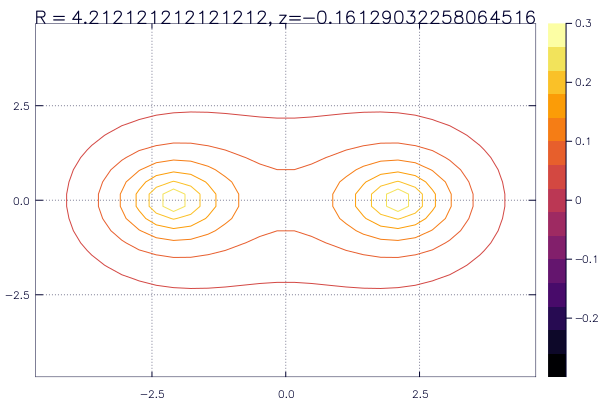

In [8]:
gr()
@manipulate for k in 1:length(Rs), j = 1:n
    ef = reshape(reshape(ψs[k], n, n, n)[j, :, :], n, n)
    contour(x, x, ef, title="R = $(Rs[k]), z=$(x[j])", zlim=[-0.3, 0.3])
end

The total energy has a minimum in the range of $R = 1.6$. The wiggles in the energy are probably due to coarse discretization and unaccurate numerical solution of the problem.

In [6]:
plot(Rs, Es, title="total energy", xlabel=L"R", ylabel=L"E")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2 
 
 
 4 
 
 
 6 
 
 
 8 
 
 
 -1.2 
 
 
 -1.0 
 
 
 -0.8 
 
 
 total energy 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 50.7108,23.3815 56.2195,112.473 61.7281,177.261 67.2367,227.182 72.7453,266.641 78.2539,297.158 83.7625,319.088 89.2711,333.138 94.7797,341.155 100.288,345.688 
 105.797,348.992 111.306,352.375 116.814,356.095 122.323,359.563 127.831,361.756 133.34,361.8 138.849,359.622 144.357,356.091 149.866,352.433 155.374,349.579 
 160.883,347.846 166.392,346.919 171.9,346.291 177.409,344.599 182.917,341.689 188.426,337.612 193.935,333.215 199.443,329.385 204.952,326.598 210.46,324.655 
 215.969,323.932 221.478,322.656 226.986,320.436 232.495,317.099 238.004,313.149 243.512,309.389 249.021,306.459 254.529,304.679 260.038,303.749 265.547,303.046 
 271.055,301.772 276.564,299.431 282.072,296.187 287.581,292.715 293.09,289.785 298.598,287.857 304.107,286.961 309.615,286.647 315.124,286.15 320.633,284.752 
 326.141,282.265 331.65,279.113 337.158,276.118 342.667,273.928 348.176,272.81 353.684,272.552 359.193,272.506 364.701,271.847 370.21,270.042 375.719,267.281 
 381.227,264.239 386.736,261.469 392.245,259.798 397.753,259.183 403.262,259.146 408.77,258.874 414.279,257.582 419.788,255.029 425.296,251.738 430.805,248.391 
 436.313,245.812 441.822,244.35 447.331,243.754 452.839,243.335 458.348,242.182 463.856,239.681 469.365,235.949 474.874,231.748 480.382,227.843 485.891,224.94 
 491.399,223.057 496.908,221.715 502.417,220.033 507.925,217.132 513.434,212.693 518.942,207.192 524.451,201.519 529.96,196.47 535.468,192.395 540.977,189.088 
 546.486,185.848 551.994,181.724 557.503,176.048 563.011,168.893 568.52,160.994 574.029,153.221 579.537,146.12 585.046,139.615 590.554,133.933 596.063,127.426 
 
 "/>
 
 
 
 
 y1